# **Cancerous Skin Legion Image Classification via Metadata Regression and Neural Networks**
    
*The project can be split into three parts:*
   * Logistic Regression on metadata and visualization of images
   * K-Means Classification on RGB Values
   * Classification using Neural Networks on greyscaled and colored 28x28 images. 
   
   
*Labeling the dataset files:*
 
*  HAM10000_metadata.csv -> Stores information regarding the individual and points to an image

*  hmnist_28_28_L.csv -> Stores the 28 x 28 greyscale pixel values for each image. We use reshape((28,28)) to shape into image format

*  hmnist_28_28_RGB.csv -> Stores the RGB values of each pixel (thus is three times as long as the previous)
 
*This dataset is comprised of approximately 10000 images of pigmented skin lesions collected over a period of 20 years, in which each lesion is diagnosed to be one of the 7 main diagnosis groups for skin cancer, defined below*:

* Akiec: Actinic Keratoses
* Bcc: Basal cell carcinoma
* Bkl: Benign keratosis
* Df: Dermatofibroma
* Nv: Melanocytic nevi
* Mel: Melanoma
* Vasc: Vascular skin lesions

*The metadata for each image includes:*

* Disease type: one of akiec, bcc, bkl, df, nv, mel, or vasc
* Diagnosis confirmation type (method in which the individual was diagnosed): histopathology (histo), follow-up examination (follow_up), expert consensus (consensus), or in-vivo confocal microscopy (confocal)
* Age of the individual (ranging from 0 to 85 years old)
* Sex of the individual (male, female, or 'unknown')
* Location of the skin lesion on the body: the dataset uses 14 distinct localizations (i.e. face, neck, lower extremity, back, etc.)
        

In [1]:
#Python 3 environment
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import copy

#Data visualization
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import statsmodels as sm
import seaborn as sns
import tensorflow as ts
import keras
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import train_test_split


#Added from external 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error

#For Neural Nets
import tensorflow 
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Flatten

import os
print(os.listdir("../input"))

Using TensorFlow backend.


['hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'ham10000_images_part_2', 'hmnist_8_8_RGB.csv', 'HAM10000_images_part_1', 'hmnist_8_8_L.csv', 'ham10000_images_part_1', 'HAM10000_metadata.csv', 'HAM10000_images_part_2']


# Classification of Lesions Based on Metadata 

In this analysis, my goal is to use solely the metadata of an individual to predict which disease type is most likely. I will use the metadata provided in HAM10000_metadata.csv to classify an individual to 1 of the 7 diagnosis. I classified individuals using different regression algorithms to predict the diagnosis for an individual solely based on the individual's sex, age, and location of lesion.

#### Step 1: Data Pre-Processing of metadata; initialization of training and test data. 
* First, we clean up the data by getting rid of rows with 'unknown' values for sex or localization., or 'NaN' values for age.

* Once our data is cleaned, we enumerate over possible values to make our metadata all real-number valued. As the age entries are already real-number valued, we only need to change our data entries for the sex and localization columns. That is, we assign male individuals to 1 and female individuals to 0, and for each of the 14 localizations, we assign the location to a number between 0 and 13 (inclusive) and change the data entries accordingly. The reason for this is so we can represent our metadata as cartesian coordinates so we can use linear regression, logistic regression, and k-means with more ease.

* Finally, once our data is cleaned and number-valued, we are ready to split the dataset into our training data and our test data. We use the sklearn.model_selection.train_test_split method to stratify over the dx column to divide the data by diagnosis, and then split the data by training on 70% and testing on the remaining 30%.

In [22]:
#Load Data
with                 open ('../input/HAM10000_metadata.csv') as metadata,   \
                     open ('../input/hmnist_28_28_L.csv')    as images,     \
                     open ('../input/hmnist_28_28_RGB.csv')  as colorImages:
    metadataDF = pd.read_csv(metadata)
    imageDF = pd.read_csv(images)  
    colorImageDF = pd.read_csv(colorImages)

In [23]:
#Cleaning up the data
#Drop empty metadata
colorImageDF = colorImageDF[metadataDF.sex != 'unknown']
colorImageDF = colorImageDF[metadataDF.age != 0]
colorImageDF = colorImageDF[metadataDF.localization != 'unknown']
colorImageDF = colorImageDF.dropna(axis=0)

imageDF = imageDF[metadataDF.sex != 'unknown']
imageDF = imageDF[metadataDF.age != 0]
imageDF = imageDF[metadataDF.localization != 'unknown']
imageDF = imageDF.dropna(axis=0)


metadataDF = metadataDF[metadataDF.sex != 'unknown']
metadataDF = metadataDF[metadataDF.age != 0]
metadataDF = metadataDF[metadataDF.localization != 'unknown']
metadataDF = metadataDF.dropna(axis=0)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


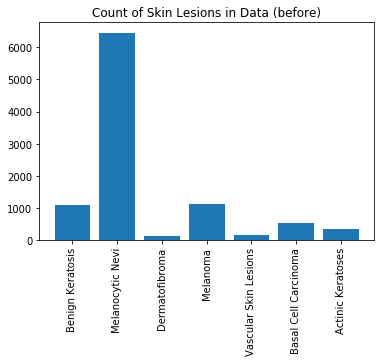

In [24]:
#Visualizing the large discrepancy 
cancerTypes = {"akiec": "Actinic Keratoses",
    "bcc": "Basal Cell Carcinoma",
    "bkl": "Benign Keratosis",
    "df": "Dermatofibroma",
    "nv": "Melanocytic Nevi",
    "mel": "Melanoma",
    "vasc": "Vascular Skin Lesions"}

countTypes = Counter(metadataDF['dx'])
plt.title("Count of Skin Lesions in Data (before)")
plt.bar([cancerTypes[x] for x in countTypes.keys()], countTypes.values())
plt.xticks(rotation='vertical')
plt.show()

As we can clearly see, there is an inbalance in the dataset. There are many more data points on melanocytic nevil. In order to balance out the dataset, we must drop some of these values.

In [25]:
colorImageBalancedDF = colorImageDF.drop(colorImageDF[colorImageDF.label == 4].iloc[:5000].index)
imageBalancedDF = imageDF.drop(imageDF[imageDF.label == 4].iloc[:5000].index)
metadataBalancedDF = metadataDF.drop(metadataDF[metadataDF.dx == 'nv'].iloc[:5000].index)

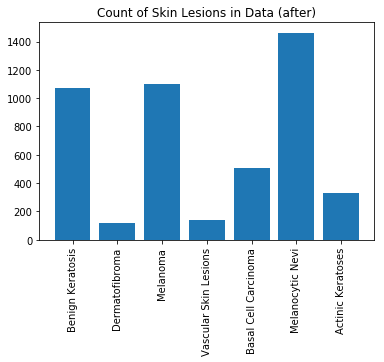

In [26]:
countTypes = Counter(metadataBalancedDF['dx'])
plt.title("Count of Skin Lesions in Data (after)")
plt.bar([cancerTypes[x] for x in countTypes.keys()], countTypes.values())
plt.xticks(rotation='vertical')
plt.show()

Now, let's explore the data a bit more.

In [27]:
#Data Visualization of Color
colorResponse = colorImageDF.label
colorPixels = colorImageDF.drop(['label'],axis=1)
colorPixels = colorPixels.values.reshape((7631456,3))
reds,greens,blues = map(list, zip(*colorPixels))

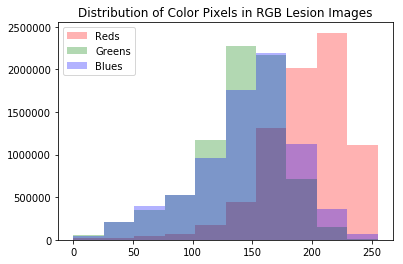

In [28]:
#Visualize the distributions
alpha = .3
colors = [(reds,'red',"Reds"),(greens,'green',"Greens"),(blues,'blue',"Blues")]

for pixels,color,label in colors:
    plt.hist(pixels,color=color,label=label,alpha=alpha)

plt.title("Distribution of Color Pixels in RGB Lesion Images")

plt.legend()
plt.show()

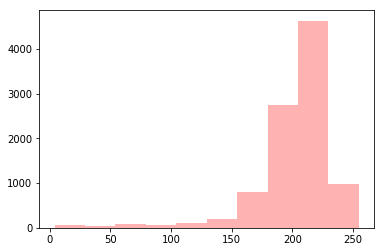

In [29]:
#Show just reds
newReds = [[]]*7
for i,r in enumerate(colorResponse): 
    newReds[r].append(reds[i])
plt.hist(newReds[2],color='red',label="ok",alpha=alpha)
plt.show()

In [30]:
#Means is the mean of reds and greens for each image
cancerType = colorImageBalancedDF['label']
colorXValues = colorImageBalancedDF.drop(['label'], axis=1)

meansRed = []
meansGreen = []
meansBlue = []
for row in colorXValues.values:
    rgb = np.array(row.reshape((784,3)))
    meansRed.append(np.mean(rgb[0]))
    meansGreen.append(np.mean(rgb[1]))
    meansBlue.append(np.mean(rgb[2]))

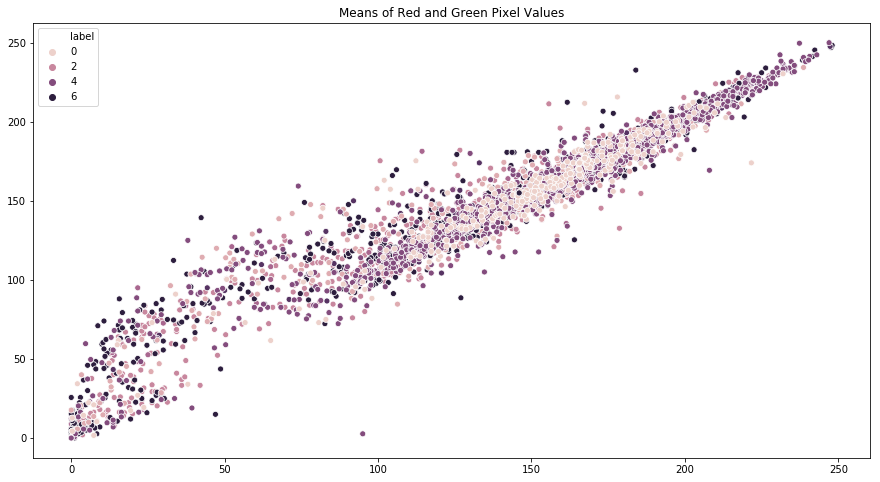

In [31]:
plt.figure(figsize=(15,8))
sns.scatterplot(meansRed, meansGreen, hue=cancerType)
plt.title('Means of Red and Green Pixel Values')
plt.show()

First Classification:
----

**Let's now try and do a logistic regression on the metadata:**

In [32]:
#Create lists for later use
diagnosis = {'bkl':0, 'nv':1, 'df':2, 'mel':3, 'vasc':4, 'bcc':5, 'akiec':6}
diagnosisColumns = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

In [33]:
sex = {'male': 1,'female': 0}
localization = {'scalp': 0,'ear': 1,'face': 2,'back': 3,'trunk': 4,
                'chest': 5,'upper extremity': 6,'abdomen': 7,'lower extremity': 8,
                'genital': 9,'neck': 10,'hand': 11,'foot': 12,'acral': 13}


In [34]:
#split data by response variable
responseColor = colorImageBalancedDF['label']
colorImageBalancedValuesDF = colorImageBalancedDF.drop(['label'], axis=1)
x_train_color, x_test_color, y_train_color, y_test_color = train_test_split(colorImageBalancedValuesDF,
                                                    responseColor,
                                                    test_size=.3, 
                                                    random_state=1, 
                                                    stratify=responseColor)

In [35]:
Counter(y_train_color)

Counter({6: 772, 4: 1029, 1: 356, 2: 750, 0: 229, 5: 97, 3: 80})

In [36]:
#split data by response variable
response = metadataBalancedDF['dx']
# we choose a test size of 0.2
x_train, x_test, y_train, y_test = train_test_split(metadataBalancedDF,
                                                    response,
                                                    test_size=.3, 
                                                    random_state=1, 
                                                    stratify=metadataBalancedDF['dx'])

In [37]:
#Create dummy variables -> One Hot Vector
x_train = pd.get_dummies(x_train.sex).join(pd.get_dummies(x_train.localization)).join(x_train.age)
x_test = pd.get_dummies(x_test.sex).join(pd.get_dummies(x_test.localization)).join(x_test.age)
x_train.shape

(3306, 16)

In [38]:
# take out acral localization
metadataBalancedDF = metadataBalancedDF[metadataBalancedDF.localization != 'acral']

In [39]:
sex_columns = ['male','female']
localization_columns = ['scalp','ear','face','back','trunk',
                        'chest','upper extremity','abdomen','lower extremity',
                        'genital','neck','hand','foot']
metadata_columns = ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']

__Step 2: Classification using Logistic Regression + Cross-Validation__

 Logistic regression is one of the most popular and effective classification algorithms, and we implement it below to predict the diagnosis for an individual based on their age, sex, and location of the lesion. It uses best-fit methods to maximize the likelihood of a diagnosis based on the training data.  However, we must be careful to not over-fit to the data, and thus we muss cross-validate our regression. We use `sklearn`'s built-in `LogisticRegressionCV` method to execute the classufication. Then, we assess the accuracy of the model on our training and test data.

In [40]:
columns = list(sex_columns)
columns.extend(localization_columns)
columns.append('age')

x_train_log = x_train[columns]
x_test_log = x_test[columns]

model = LogisticRegressionCV(
                        Cs=list(np.power(10.0, np.arange(-10, 10))),
                        max_iter=10000,
                        fit_intercept=True,
                        cv=5
)
model.fit(x_train_log,y_train)

#Predict
y_pred_train = model.predict(x_train_log)
y_pred_test = model.predict(x_test_log)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training Set Accuracy: 41.560798548094375%
Testing Set Accuracy: 41.74894217207334%


In [41]:
#Show the coefficients
coefs = pd.DataFrame(model.coef_.T, columns=diagnosisColumns)
rows = list(sex_columns)
rows.extend(localization_columns)
rows.append('age')
coefs['Predictor'] = rows
print("Coefficients from model:")
display(coefs)

Coefficients from model:


,bkl,nv,df,mel,vasc,bcc,akiec,Predictor
0,1.789702e-09,1.152505e-09,-0.078878,-7.848101e-10,0.078867,-0.020084,-6.802135e-10,male
1,-1.789715e-09,-1.152593e-09,0.079172,7.848180e-10,-0.181273,0.015421,6.804262e-10,female
2,3.320014e-10,5.169956e-10,0.033088,-1.984268e-10,-0.482433,0.007498,-1.405875e-10,scalp
3,-1.078043e-10,-3.230502e-10,-0.032264,-7.259517e-11,1.345337,0.023341,-8.801980e-11,ear
4,5.475131e-09,1.831195e-09,0.468870,-1.161523e-09,-0.326262,-0.524934,-1.108317e-09,face
5,-4.237148e-09,4.559263e-09,-0.215291,-2.043978e-09,0.268565,0.285980,-1.199519e-09,back
6,-1.343799e-09,-1.289053e-09,0.049369,-4.694489e-10,-0.133498,0.071620,2.230804e-09,trunk
7,-6.100432e-10,5.525047e-10,0.030788,-5.275250e-10,0.298231,0.010558,-1.396108e-10,chest
8,1.183815e-09,-1.133467e-09,-0.178055,5.812471e-10,0.810069,-0.113266,-4.352116e-10,upper extremity
9,-8.953109e-10,-1.313674e-09,-0.084656,-1.525102e-10,0.425177,0.086043,1.251342e-09,abdomen


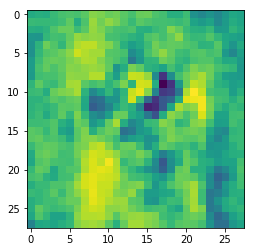

In [42]:
#Visualizing image greyscale 
testImage = np.array([imageDF.iloc[0][:784]])
testImage = testImage.reshape((28,28))
testImage.shape
plt.imshow(testImage)
plt.show()

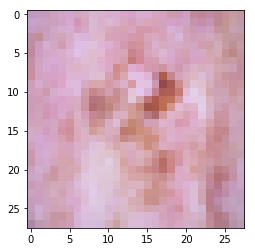

In [43]:
#Visualizing RGB image with python plt
testImage = np.array([colorImageDF.iloc[0]])
testImage = testImage[0][:2352]
testImage = testImage.reshape((28,28,3))
plt.imshow(testImage)
plt.show()

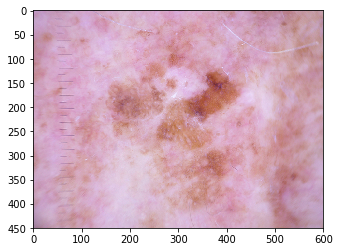

In [44]:
#Visualizing full image from file
filepath = "../input/ham10000_images_part_1/ISIC_0027419.jpg"
image = mpimg.imread(filepath)
plt.imshow(image)
plt.show()

K-Means: 
----


In [45]:
class KMeansClassifier(object):
   

    def __init__(self, K, centers, points):
        self.K = K
        self.centers = centers
        self.points = points
        self.count = 0

        # clusters[i] contains all points assigned to it
        self.clusters = [[] for _ in range(K)]

    def fit(self):
        i = 0
        while True:
            prev_centers = copy.deepcopy(self.centers)
            self.clusters = [[] for _ in range(self.K)]

            self.assign_clusters()
            self.update_centers()

            # Stop once we have converged
            if prev_centers == self.centers:
                break
            i += 1
            self.count += 1
            if self.count == 30: 
                break

    def assign_clusters(self):
        for point in self.points: 
            minDistance = float("Inf")
            centerIndex = None
            for i,center in enumerate(self.centers): 
                distance = np.linalg.norm(np.subtract(point,center))
                if distance < minDistance: 
                    minDistance = distance
                    centerIndex = i
            self.clusters[centerIndex].append(point)
        
    def update_centers(self):
        for i,cluster in enumerate(self.clusters): 
            first = [c[0] for c in cluster]
            second = [c[1] for c in cluster]
            #third = [c[2] for c in cluster]
            
            self.centers[i] = [np.mean(first), np.mean(second)] #,np.mean(third)]
        
    def classify(self, point):
        pass
    def error(self):
        error = 0
        for i,cluster in enumerate(self.clusters): 
            for point in cluster: 
                center = self.centers[i]
                distanceSquared = np.linalg.norm(np.subtract(point,center))**2
                error += distanceSquared
        return error

def makeMeans(k,points,centers):
    print("computing kmeans for k=", k);

    kmeans = KMeansClassifier(k, centers, points)
    kmeans.fit()
    print('Error: {}'.format(kmeans.error()))
    plt.figure(figsize=(17,12))
    for cluster in kmeans.clusters:
        try:
            plt.plot(list(zip(*cluster))[0], list(zip(*cluster))[1], 'o')
        except:
            continue
    plt.plot(list(zip(*kmeans.centers))[0], list(zip(*kmeans.centers))[1], 'x')
    plt.title('KMeans with k=' + str(k))
    plt.savefig('kmeans.png')
    plt.show()
    print(kmeans.centers)

In [46]:
meansTrain = []
for row in x_train_color.values:
    rgb = np.array(row.reshape((784,3)))
    meansTrain.append([np.mean(rgb[0]), np.mean(rgb[1])])

meansTest = []
for row in x_test_color.values:
    rgb = np.array(row.reshape((784,3)))
    meansTest.append([np.mean(rgb[0]), np.mean(rgb[1])])


#Means is the mean of reds and greens for each image

computing kmeans for k= 7
Error: 739034.8812419522


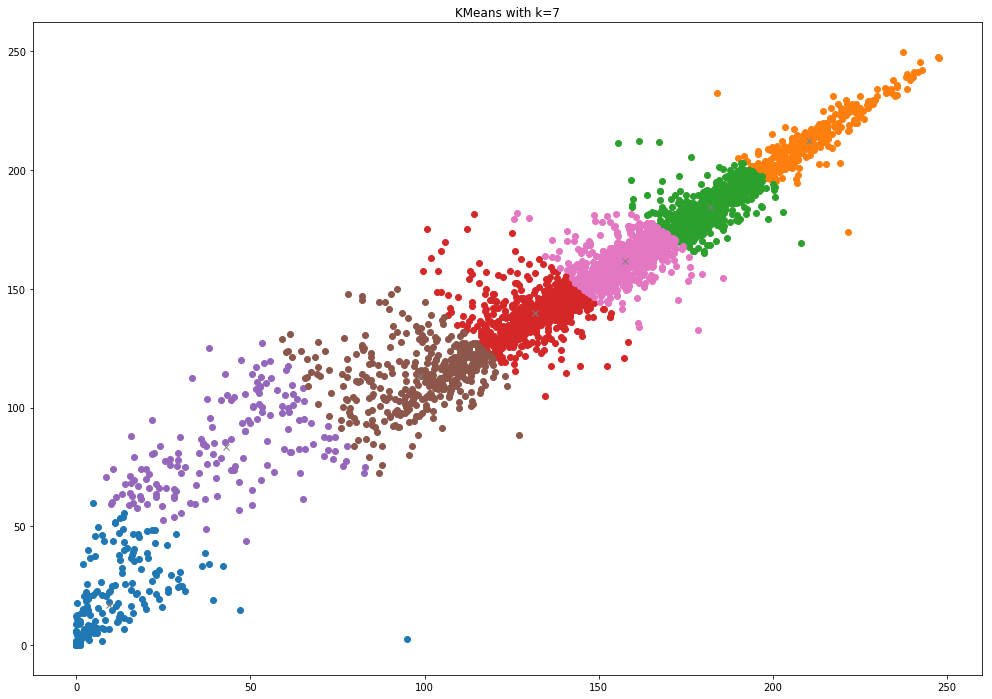

[[9.286858974358974, 17.025641025641026], [210.43440233236151, 212.08649173955297], [181.8527233115468, 184.65141612200432], [131.65005192107995, 139.92471443406023], [42.9047619047619, 83.4513457556936], [98.8307426597582, 113.46027633851469], [157.62128712871288, 161.73308580858085]]


In [47]:
# initialize 7 reasonably random centroids
centers = [[10,10],[250,250],[174,174],[120,130],[75,75],[123,123],[215,123]]
meansTrain = np.array(meansTrain)
makeMeans(7,meansTrain,centers)

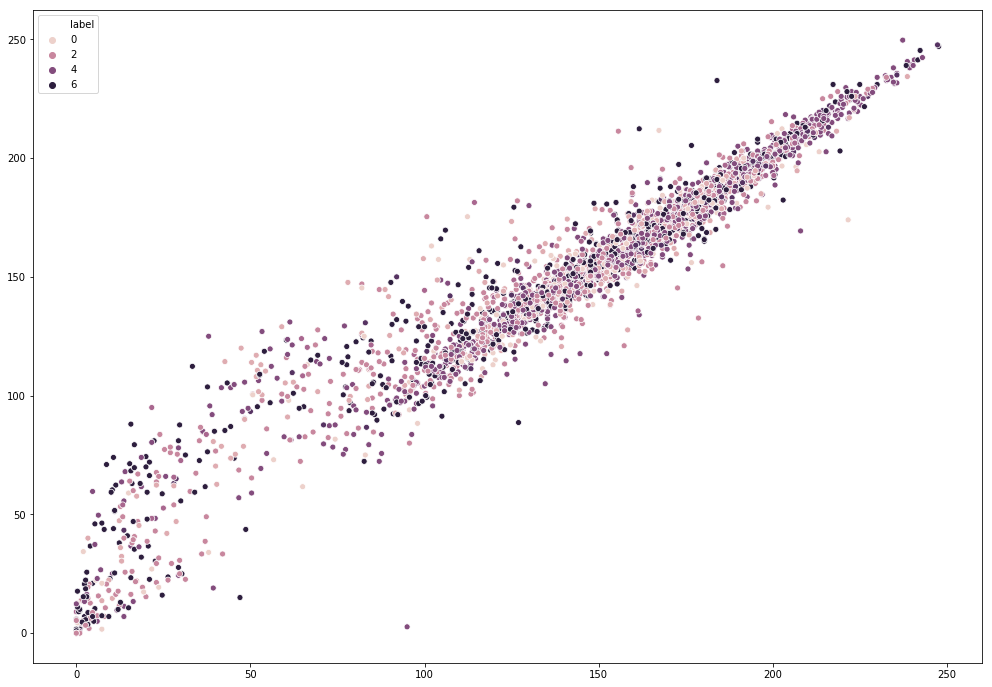

In [48]:
plt.figure(figsize=(17,12))
sns.scatterplot(meansTrain[:,0], meansTrain[:,1], hue=y_train_color)
plt.show()

Neural Network:
----





In [49]:
#split data by response variable
response = imageBalancedDF['label']
predictors = imageBalancedDF.drop(['label'], axis=1)
# we use a test size of 0.5 as training takes much longer
X_train, X_test, Y_train, Y_test = train_test_split(predictors,
                                                    response,
                                                    test_size=.5, 
                                                    random_state=1, 
                                                    stratify=response)

In [50]:
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)

In [51]:
X_train_normal = (X_train.values - np.mean(X_train.values))/np.std(X_train.values)
X_test_normal = (X_test.values - np.mean(X_test.values))/np.std(X_test.values)

In [52]:
from keras import regularizers
#nodes in the layers: 30 to 30 to 30 to 1
input_dim = X_train_normal.shape[1] # input dimension: just x
model = Sequential()

# our first hidden layer
model.add(Dense(40, input_dim=input_dim, 
                activation='relu',  kernel_regularizer=regularizers.l2(0.01))) 

# our first hidden layer
model.add(Dense(40,
                activation='relu',  kernel_regularizer=regularizers.l2(0.01)),  ) 

# our third hidden layer
model.add(Dense(40,activation='relu',  kernel_regularizer=regularizers.l2(0.01)))

# Our output layer
model.add(Dense(7, kernel_initializer='normal', activation='softmax',input_dim=40)) 

# compile it 
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Summary 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                31400     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 287       
Total params: 34,967
Trainable params: 34,967
Non-trainable params: 0
_________________________________________________________________


In [53]:
batch_size = 32
epochs = 60

# fit the model
model_history = model.fit(X_train_normal, Y_train, 
                          batch_size=batch_size, 
                          validation_data=(X_test_normal, Y_test), 
                          epochs=epochs, 
                          verbose=1)

Train on 2367 samples, validate on 2367 samples
Epoch 1/60
2367/2367 [==============================] - 1s 256us/step - loss: 3.3222 - acc: 0.2962 - val_loss: 3.1641 - val_acc: 0.3612
Epoch 2/60
2367/2367 [==============================] - 0s 92us/step - loss: 3.0866 - acc: 0.3638 - val_loss: 3.0443 - val_acc: 0.3735
Epoch 3/60
2367/2367 [==============================] - 0s 94us/step - loss: 3.0015 - acc: 0.3823 - val_loss: 2.9788 - val_acc: 0.3857
Epoch 4/60
2367/2367 [==============================] - 0s 94us/step - loss: 2.9376 - acc: 0.3823 - val_loss: 2.9262 - val_acc: 0.3790
Epoch 5/60
2367/2367 [==============================] - 0s 94us/step - loss: 2.8835 - acc: 0.3988 - val_loss: 2.8769 - val_acc: 0.3836
Epoch 6/60
2367/2367 [==============================] - 0s 92us/step - loss: 2.8299 - acc: 0.4026 - val_loss: 2.8309 - val_acc: 0.3815
Epoch 7/60
2367/2367 [==============================] - 0s 92us/step - loss: 2.7811 - acc: 0.4111 - val_loss: 2.7868 - val_acc: 0.3802
Epoch 

60
Loss: train=1.566, test=1.805


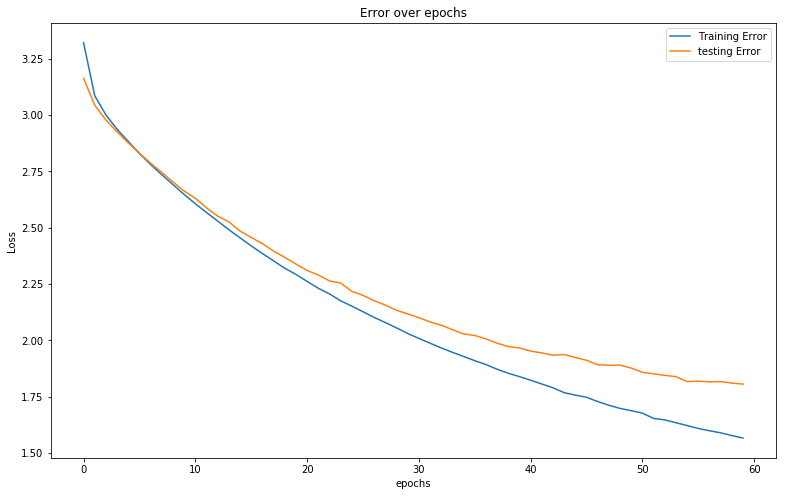

In [54]:
plt.figure(figsize=(13,8))

# Plotting the train and validation errors
plt.plot(model_history.history['loss'], label = 'Training Error')
plt.plot(model_history.history['val_loss'], label = 'testing Error')
plt.title("Error over epochs")
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend();
plt.savefig('error.png')
print(len(model_history.history['loss']))
print("Loss: train={:.3f}, test={:.3f}".format(
    model_history.history['loss'][-1],
    model_history.history['val_loss'][-1]))

60
Accuracy: train=0.561, test=0.451


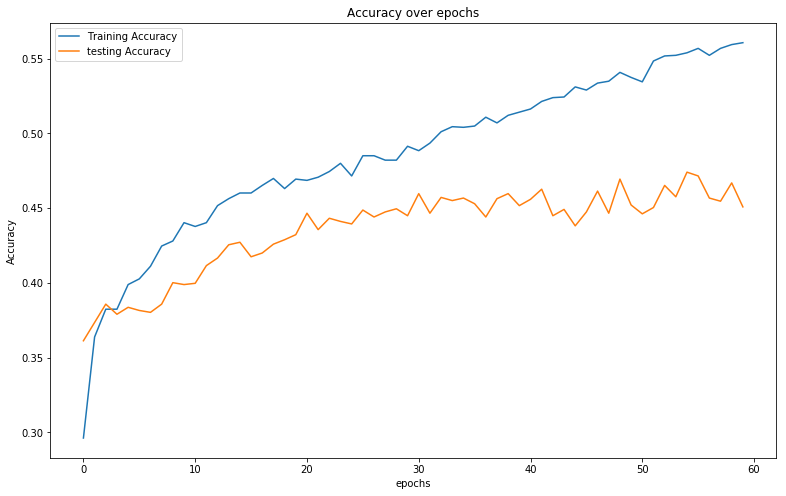

In [55]:
plt.figure(figsize=(13,8))

# Plotting the train and validation errors
plt.plot(model_history.history['acc'], label = 'Training Accuracy')
plt.plot(model_history.history['val_acc'], label = 'testing Accuracy')
plt.title("Accuracy over epochs")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend();
plt.savefig('accuracy.png')
print(len(model_history.history['acc']))
print("Accuracy: train={:.3f}, test={:.3f}".format(
    model_history.history['acc'][-1],
    model_history.history['val_acc'][-1]))

In [56]:
predictions = model.predict(X_train)

In [57]:
Counter(colorImageBalancedDF['label'])

Counter({2: 1071, 3: 115, 6: 1103, 5: 138, 1: 509, 4: 1471, 0: 327})

In [58]:
pd.DataFrame(predictions).sample(5)

,0,1,2,3,4,5,6
2033,0.0,1.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0
2053,0.0,1.000000e+00,0.0,0.0,4.044404e-17,0.0,0.0
1524,0.0,1.000000e+00,0.0,0.0,1.410624e-16,0.0,0.0
1982,0.0,3.627009e-19,0.0,0.0,1.000000e+00,0.0,0.0
1611,0.0,1.000000e+00,0.0,0.0,5.616604e-15,0.0,0.0


In [59]:
pd.DataFrame(Y_train).sample(5)

,0,1,2,3,4,5,6
363,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2214,0.0,0.0,1.0,0.0,0.0,0.0,0.0
139,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1676,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1160,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Now using a Convolutional Neural Net on colored images (28x28 pixels)

In [60]:
#split data by response variable
response = colorImageBalancedDF['label']
predictors = colorImageBalancedDF.drop(['label'], axis=1)
# test size of 0.5 again
X_train, X_test, Y_train, Y_test = train_test_split(predictors,
                                                    response,
                                                    test_size=.5, 
                                                    random_state=1, 
                                                    stratify=response)

In [61]:
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)

In [62]:
X_train_normal = (X_train.values - np.mean(X_train.values))/np.std(X_train.values)
X_test_normal = (X_test.values - np.mean(X_test.values))/np.std(X_test.values)

In [63]:
TRAIN_X_SHAPE = X_train_normal.reshape(2367, 28,28,3)
TEST_X_SHAPE = X_test_normal.reshape(2367, 28,28,3)

In [64]:
import keras.backend as K
K.set_image_dim_ordering('tf')
model = Sequential()
# add layers of CNN (we can play around with these numbers to get better accuracy)
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(28,28,3), kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model.add(Dropout(0.3))
model.add(Dense(7, activation = 'softmax'))

In [65]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 5, 64)          256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
__________

In [ ]:
batch_size = 32
epochs = 20

# fit the model
model_history = model.fit(TRAIN_X_SHAPE, Y_train, 
                          batch_size=batch_size, 
                          validation_data=(TEST_X_SHAPE, Y_test), 
                          epochs=epochs, 
                          verbose=1)

Train on 2367 samples, validate on 2367 samples
Epoch 1/20
2367/2367 [==============================] - 5s 2ms/step - loss: 4.3985 - acc: 0.3971 - val_loss: 4.1436 - val_acc: 0.4736
Epoch 2/20
2367/2367 [==============================] - 4s 2ms/step - loss: 4.0390 - acc: 0.4896 - val_loss: 3.9753 - val_acc: 0.4985
Epoch 3/20
2367/2367 [==============================] - 4s 2ms/step - loss: 3.8370 - acc: 0.5395 - val_loss: 3.8514 - val_acc: 0.5150
Epoch 4/20
 416/2367 [====>.........................] - ETA: 2s - loss: 3.7524 - acc: 0.5529

In [ ]:
plt.figure(figsize=(13,8))

# Plotting the train and validation errors
plt.plot(model_history.history['loss'], label = 'Training Error')
plt.plot(model_history.history['val_loss'], label = 'testing Error')
plt.title("Error over epochs")
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend();
plt.savefig('error.png')
print(len(model_history.history['loss']))
print("Loss: train={:.3f}, test={:.3f}".format(
    model_history.history['loss'][-1],
    model_history.history['val_loss'][-1]))

In [ ]:
plt.figure(figsize=(13,8))

# Plotting the train and validation errors
plt.plot(model_history.history['acc'], label = 'Training Accuracy')
plt.plot(model_history.history['val_acc'], label = 'testing Accuracy')
plt.title("Accuracy over epochs")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend();
plt.savefig('accuracy.png')
print(len(model_history.history['acc']))
print("Accuracy: train={:.3f}, test={:.3f}".format(
    model_history.history['acc'][-1],
    model_history.history['val_acc'][-1]))

In [ ]:
predictions = model.predict(TEST_X_SHAPE)
pd.DataFrame(predictions).sample(5)

In [ ]:
pd.DataFrame(Y_train).sample(5)